In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [53]:
df_filepaths = 'data/univ3/*.parquet'

### Monthly Blockchain Volume

In [58]:
def get_weekly_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    '''
    Returns weekly volume for each blockchain in USD
    '''
    q = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('amountInUSD') < 150000000)
    .filter(pl.col('blockchain') == blockchain)
    .sort("timestamp", descending=False)
    .with_columns(pl.col("timestamp").dt.round("1w").alias("timestamp"))
    .groupby("timestamp", maintain_order=True).agg(pl.col('amountInUSD').sum().alias("weekly_vol"))
    )

    df = q.collect()

    return df

In [59]:
eth_data = get_weekly_vol(df_filepaths, 'ethereum')
arb_data = get_weekly_vol(df_filepaths, 'arbitrum')
opt_data = get_weekly_vol(df_filepaths, 'optimism')
poly_data = get_weekly_vol(df_filepaths, 'polygon')
bsc_data = get_weekly_vol(df_filepaths, 'bsc')

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [62]:
# rename columns
eth_data = eth_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('eth_vol')
)

arb_data = arb_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('arb_vol')
)

opt_data = opt_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('opt_vol')
)

poly_data = poly_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('poly_vol')
)

bsc_data = bsc_data.select(
    pl.col('timestamp').alias('timestamp'),
    pl.col('weekly_vol').alias('bsc_vol')
)

In [63]:
# merge dataframes
weekly_vol = eth_data.join(arb_data, on='timestamp').join(opt_data, on='timestamp').join(poly_data, on='timestamp').join(bsc_data, on='timestamp', how='outer')

In [64]:
# convert null to 0 
weekly_vol = weekly_vol.fill_null(0)

In [65]:
# for index in range(1, weekly_vol.shape[1]):
#     for col in weekly_vol.rows():
#         print(col[0], weekly_vol.columns[index], '${:,.2f}'.format(col[index]))

In [66]:
# change timestamp from datetime to date
weekly_vol = weekly_vol.with_columns(pl.col('timestamp').dt.date())

In [67]:
# filter weekly vol for after 2023-04-1
weekly_vol = weekly_vol.filter(pl.col('timestamp') >= pl.date(2023,4,1))

In [74]:
# drop timestamp columns after 2023-7-1
weekly_vol = weekly_vol.filter(pl.col('timestamp') < pl.date(2023,7,1))

### Plotting

In [75]:
# convert to pandas for plotting
pd_chart = weekly_vol.to_pandas()

In [76]:
# fill nans with 0
pd_chart = pd_chart.fillna(0)

In [77]:
pd_chart

,timestamp,eth_vol,arb_vol,opt_vol,poly_vol,bsc_vol
0,2023-04-03,4.600078e+09,2.905219e+09,1.668781e+08,2.179669e+08,1.872867e+08
1,2023-04-10,3.581329e+09,1.769172e+09,1.448357e+08,2.059927e+08,6.051346e+08
2,2023-04-17,5.212094e+09,3.632003e+09,2.448900e+08,3.959018e+08,9.249245e+08
3,2023-04-24,4.277207e+09,2.986329e+09,1.763367e+08,5.043719e+08,1.010973e+09
4,2023-05-01,3.355808e+09,1.846882e+09,1.363779e+08,3.578247e+08,9.237096e+08
5,2023-05-08,5.361199e+09,2.123735e+09,1.769378e+08,2.786788e+08,2.835878e+08
6,2023-05-15,4.140276e+09,1.510905e+09,1.435157e+08,1.137788e+08,5.640015e+08
7,2023-05-22,2.713178e+09,1.062099e+09,1.145648e+08,1.596279e+08,5.266307e+08
8,2023-05-29,3.592867e+09,1.212252e+09,1.252754e+08,2.826540e+08,5.791380e+08
9,2023-06-05,3.821852e+09,1.497873e+09,1.340848e+08,3.111849e+08,7.503468e+08


In [78]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

In [79]:
# Try to convert to numpy arrays? Values not showing properly for optimism.
# one solution is to use numpy arrays for better elementwise addition? https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib

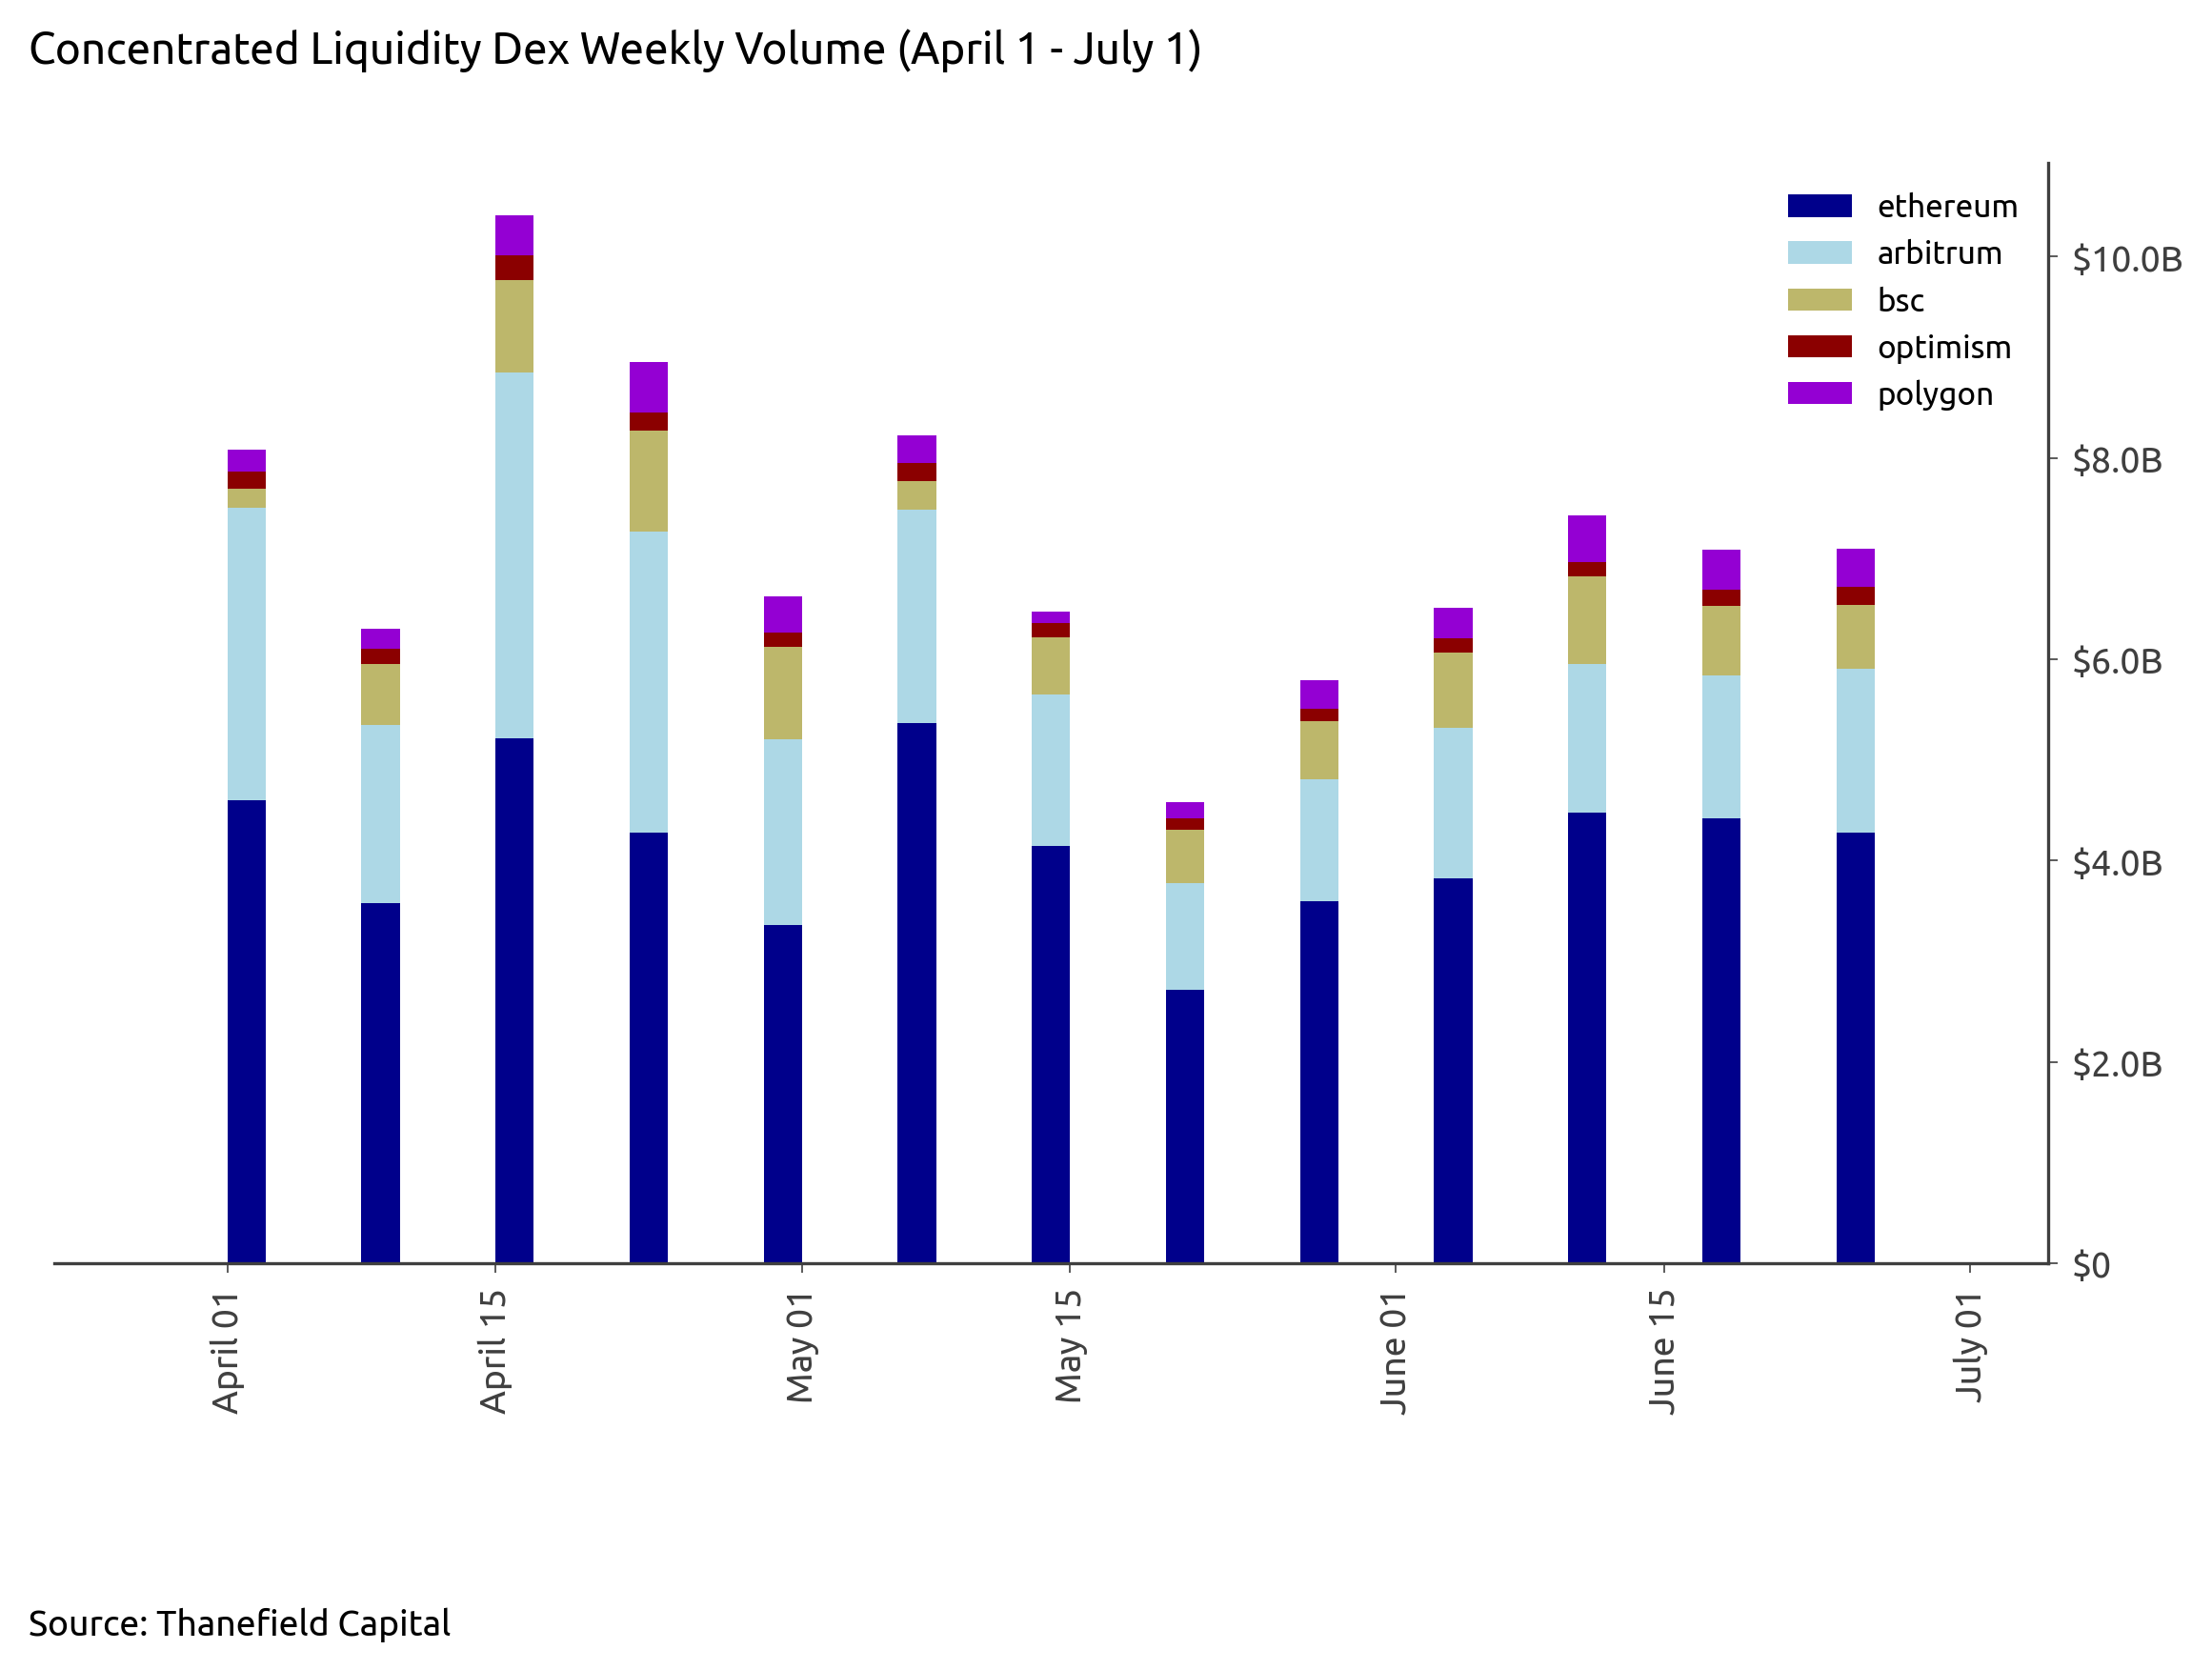

In [80]:
# Create the bar chart
fig, ax = tc.chart('Concentrated Liquidity Dex Weekly Volume (April 1 - July 1)', dates=False)
ax.bar(pd_chart['timestamp'], pd_chart['eth_vol'], color='darkblue', label='ethereum', align='edge', width=-2)
ax.bar(pd_chart['timestamp'], pd_chart['arb_vol'], color='lightblue', label='arbitrum', align='edge', width=-2, bottom=pd_chart['eth_vol'])
ax.bar(pd_chart['timestamp'], pd_chart['bsc_vol'], color='darkkhaki', label='bsc', align='edge', width=-2, bottom=pd_chart['eth_vol']+pd_chart['arb_vol'])
ax.bar(pd_chart['timestamp'], pd_chart['opt_vol'], color='darkred', label='optimism', align='edge', width=-2, bottom=pd_chart['eth_vol']+pd_chart['arb_vol']+pd_chart['bsc_vol'])
ax.bar(pd_chart['timestamp'], pd_chart['poly_vol'], color='darkviolet', label='polygon', align='edge', width=-2, bottom=pd_chart['eth_vol']+pd_chart['arb_vol']+pd_chart['bsc_vol']+pd_chart['opt_vol'])


# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))


# formatting
tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
# plt.tight_layout()
plt.xticks(rotation=90)

# save chart
tc.save('charts/dex_weekly_vol.png')